# SE3 implementation

In [4]:
import os
import time
from copy import copy
from pathlib import Path
from pdb import set_trace

import matplotlib.pyplot as plt
import numpy as np
import psutil
import src.se3.visualization as viz
import torch
import torch.nn as nn
from se3_transformer_pytorch.irr_repr import rot

from src.ri_distances.SGW.risgw import RISGW_loss
from src.se3.torch_funcs import MachineScaleChecker, visualize_prediction, get_model, train_one_epoch
from src.se3.visualization import viz_point_cloud
from src.ri_distances.pnt_cloud_generation import get_src_scaled_spirals, get_src_shifted_spirals, get_spiral,center

import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.style.use('ggplot')
model_path = Path("/content/drive/MyDrive/se3_transformer.pt")
torch.set_default_dtype(torch.float32) # works best in float64


You can visualize the type of point cloud you overfit in this cell

## Experiment 3

We define the various parameter for the SE3 training

Loading fresh model


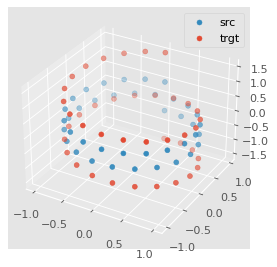

In [36]:
transformer = get_model()
epochs = 30
criterion = torch.nn.MSELoss()
batch_size = 2
lr = 0.01
optimizer = torch.optim.Adam(transformer.parameters(),lr=lr)
# optimizer = torch.optim.SGD(transformer.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       patience=100,
                                                       factor=0.4,
                                                       threshold=0.001,
                                                       verbose=True)

center_input = True
center_output = True
center_target = True

batch_f = get_src_scaled_spirals
batch_f_kwargs = {'center_input':center_input,'center_target':center_target}
use_wandb = False
points, target_points = batch_f(**batch_f_kwargs)
viz_point_cloud([(points,'src'),(target_points,'trgt')])#,[cent_points,cent_target_points])

In [37]:
if use_wandb:
    wrun = wandb.init("se3_runs")
    config = wandb.config
    config.criterion = criterion
    config.optimizer = optimizer
    config.lr = lr
    config.batch_f = batch_f
    config.batch_f_kwargs = batch_f_kwargs
    config.center_input = center_input
    config.center_target = center_target
    config.center_output = center_output
    wandb.watch(transformer)
for epoch in range(epochs):
    train_args = {"model":transformer,
                "use_wandb":use_wandb,
                "optimizer":optimizer,
                "epoch":epoch,
                "criterion":criterion,
                "batch_size":batch_size,
                "scheduler":scheduler,
                "device":device,
                "batch_f":batch_f,
                "batch_f_kwargs":batch_f_kwargs,
                "center_output":center_output}
    loss = train_one_epoch(**train_args)

Epoch 0
Loss: 0.11637500673532486
Epoch 1
Loss: 0.15992537140846252
Epoch 2
Loss: 48.71785354614258
Epoch 3
Loss: 0.12155842036008835
Epoch 4
Loss: 0.14996623992919922
Epoch 5
Loss: 0.16413968801498413
Epoch 6
Loss: 0.42835861444473267
Epoch 7
Loss: 0.1949187070131302
Epoch 8
Loss: 0.16589055955410004
Epoch 9
Loss: 0.18773575127124786
Epoch 10
Loss: 0.102595254778862
Epoch 11
Loss: 0.18731854856014252
Epoch 12
Loss: 0.0871247872710228
Epoch 13
Loss: 0.14016848802566528
Epoch 14
Loss: 0.15866811573505402
Epoch 15
Loss: 0.15327352285385132
Epoch 16
Loss: 0.13905276358127594
Epoch 17
Loss: 0.12707921862602234
Epoch 18
Loss: 0.11322428286075592
Epoch 19
Loss: 0.11081553995609283
Epoch 20
Loss: 0.1159975603222847
Epoch 21
Loss: 0.13461154699325562
Epoch 22
Loss: 0.11529573798179626
Epoch 23
Loss: 0.11359427869319916
Epoch 24
Loss: 0.12071102112531662
Epoch 25
Loss: 0.11738203465938568
Epoch 26
Loss: 0.12270619720220566
Epoch 27
Loss: 0.1238325834274292
Epoch 28
Loss: 0.11956670880317688
Epo

## Visualize results

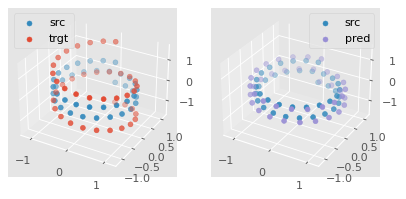

In [38]:
fig = visualize_prediction(transformer, batch_f, batch_f_kwargs, center_output)
if use_wandb:
    wandb.log({"chart": wandb.Image(fig)})
fig

In [18]:
wrun.finish()

In [28]:
dist_pred_target = torch.nn.MSELoss()(predicted_points_tens,target_points_tens_raw)
dist_centtarg_target = torch.nn.MSELoss()(target_points_tens,target_points_tens_raw)
print(dist_pred_target)
print(dist_centtarg_target)

tensor(0.8670, grad_fn=<MseLossBackward>)
tensor(0.7502)


## Is the output systematically centered?

In [35]:
N = 25
scale = 1000
shift = 500
rand_points_tens = torch.rand(1,N,3) * scale # we scale the noise
rand_points_tens += torch.tensor([shift,shift,shift]) # and shift the point cloud
predicted_deltas_tens = predict(transformer,rand_points_tens)
print(f"Input barycenter:{rand_points_tens.mean(axis=1)}")
print(f"Output barycenter:{predicted_deltas_tens.mean(axis=1)}")

Input barycenter:tensor([[1008.4020, 1085.2714,  978.3622]])
Output barycenter:tensor([[ 6.5305e-08, -5.3242e-08, -2.1842e-08]], grad_fn=<MeanBackward1>)
